# Simple Power Plant Modeling
-----------------------------------

_[GPkit](https://github.com/appliedopt/gpkit) for model representation and solver interfacing._

### Design objective

An airplane with that consumes as little fuel as possible when cruising (while remaining capable of taking off from the ground, with wings that won't break, etc.)

### To Do

abstract kelvin


## 1. Set up the modeling environment

Start by importing Numpy and GPkit, and turning on LaTex printing for GPkit variables and equations:

In [24]:
#import pkg_resources
#pkg_resources.require("ipywidgets==4.1.1")
import ipywidgets
print ipywidgets.__version__

import numpy as np
import gpkit
import gpkit.interactive

6.0.0


In [25]:
import IPython
print IPython.__version__


5.4.1


Next declare constants (including take-off and cruising speed, which will be 'swept' over a range of values):

In [26]:
# V = gpkit.Variable("V", ("sweep", np.linspace(45, 55, 5)), "m/s", "cruising speed")  # sweep and autosweep dont work well together
# V = gpkit.Variable("V", 50, "m/s", "cruising speed")
T_h = gpkit.Variable("T_{h}", 673, "K", "turbine hot inlet temperature")
T_a = gpkit.Variable("T_{a}", 313, "K", "ambient temperature")
pi = gpkit.Variable("\\pi", np.pi, "-", "half of the circle constant")
C_BoP = gpkit.Variable("C_{BoP}", 1e6, "-", "cost of balance of plant")  # pint doesn't like $ unit?
C_fuel = gpkit.Variable("C_{fuel}", 200, "1/kg", "price of fuel")
P_fuel = gpkit.Variable("P_{fuel}", 300, "W/kg", "fuel power")



Then declare the rest of the variables (there's no need to separate variables and constants like this, I just find it a little more readable):

In [27]:
eta = gpkit.Variable("\\eta", 0.5, "-", "plant carnot efficiency")

P_e = gpkit.Variable("P_{e}", "W", "plant electric power")
P_th = gpkit.Variable("P_{th}", "W", "core thermal power")
T_c = gpkit.Variable("T_{c}", "K", "turbine cold temperature")
DT = gpkit.Variable("DT", "K", "delta temperature")
C_core = gpkit.Variable("C_{core}", "-", "core cost")
C_tot = gpkit.Variable("C_{tot}", "-", "total plant cost")
m_fuel = gpkit.Variable("m_{fuel}", "kg", "total fuel mass")


## 2. Write the system's equations

The drag and wing-weight models consist of several sub-models, so we'll write them here for convenience:

In [28]:
equations = []


# T_c = T_a + 20*gpkit.units.K                  # ambient temp standoff
# T_h = DT + T_c
# eta = DT/T_h                                   # efficiency


# equations += [1 >= eta + T_c*T_h**-1]

# equations += [eta <= (T_h + T_c*(-1))/T_h]   # doesnt like negative


C_core = C_fuel*m_fuel
equations += [C_tot >= C_BoP + C_core]

P_th = P_fuel*m_fuel
equations += [P_e >= eta*P_th]               

  

In [29]:
equations

[gpkit.PosynomialInequality(C_{tot} >= C_{BoP} + C_{fuel}*m_{fuel}),
 gpkit.PosynomialInequality(P_{e} >= P_{fuel}*\eta*m_{fuel})]

In [30]:
m = gpkit.Model(C_tot,         # Minimize total plant cost
                equations)     # subject to our model

We can check that we've got the right equations by examining the LaTex representation of the system:

In [31]:
m

gpkit.Model(
  # minimize
        C_{tot}
  # subject to
        C_{tot} >= C_{BoP} + C_{fuel}*m_{fuel}
        P_{e} >= P_{fuel}*\eta*m_{fuel})

## 3. Solve the system

In [32]:
data = m.solve()
print data.table()

P_{e} has no upper bound
m_{fuel} has no lower bound
Using solver 'cvxopt'
Solving for 3 variables.
Solving took 0.00923 seconds.

Cost
----
 1e+06

Free Variables
--------------
 C_{tot} : 1e+06           total plant cost
   P_{e} : 0.1481     [W]  plant electric power
m_{fuel} : 0.0003633  [kg] total fuel mass

Constants
---------
 C_{BoP} : 1e+06         cost of balance of plant
C_{fuel} : 200    [1/kg] price of fuel
P_{fuel} : 300    [W/kg] fuel power
    \eta : 0.5           plant carnot efficiency

Sensitivities
-------------
 C_{BoP} : +1       cost of balance of plant
C_{fuel} : +7.3e-08 price of fuel
P_{fuel} : +1e-16   fuel power
    \eta : +1e-16   plant carnot efficiency



In [33]:
%matplotlib inline        
                            # optional, displays plots in notebook
%config InlineBackend.figure_format = 'retina'
#m.controlpanel([k, mu, rho, A, S, W])  # currently broken due to ipywidgets 6.0.0 update

m.autosweep({T_a: (293, 313)}, tol=0.001).plot()  # variable inside plot() is y axis, default is cost

#sol = m.autosweep({rho: (0.8, 1.6)}, tol=0.001, verbosity=0)
#f, ax = sol.plot(W)
#ax.set_title("blah")
#f.show()
#m.interactive([k, mu, rho, A, S, W])   # currently broken due to ipywidgets 6.0.0 update

KeyError: gpkit.Variable(T_{a} [K])

## 4. Analyze the system's optimal frontier

GPkit uses matplotlib to visualize the optimal ('Pareto') frontier of a system.

We'll start up the iPython Notebook plotting environment so we can use them:

Plotting any particular design variables is then quite straightforward:

In [ ]:
#gpkit.interactive.plotting.plot_frontiers(m, [D, C_D, C_L], 1, 3, (5,5))  # currently broken due to ipywidgets 6.0.0 update

We can see that drag does not increase with cruising speed as drastically as might have been expected.

This is because (under the assumptions of our equations) increasing speed allows one to fly with a smaller and lighter wing.

But don't believe me, take a look at the graphs!

In [ ]:
#gpkit.interactive.plotting.plot_frontiers(m, [W_w, S, A], 1, 3, (5,5))  # currently broken due to ipywidgets 6.0.0 update

[1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3]
[15 16 17 18 19 20 15 16 17 18 19 20 15 16 17 18 19 20]
[  5.    4.    4.    3.    2.    0.1   9.    8.    7.    6.    4.5   1.5
  11.    9.    8.    7.    5.    2.5]


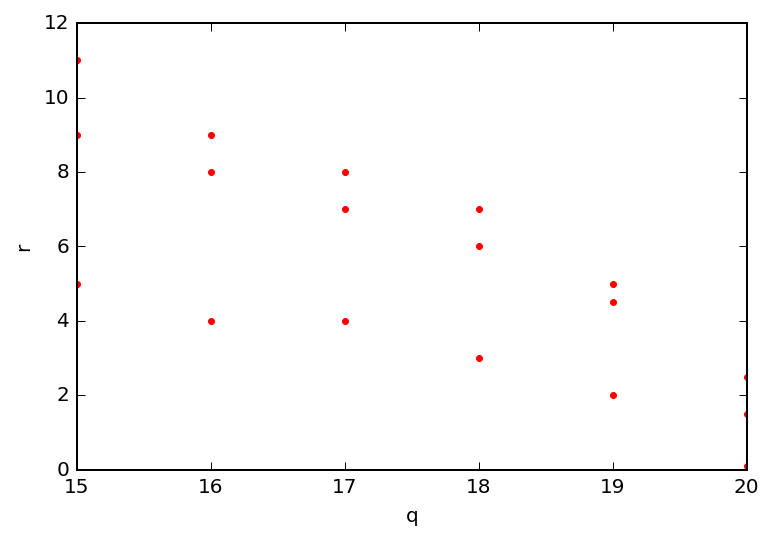

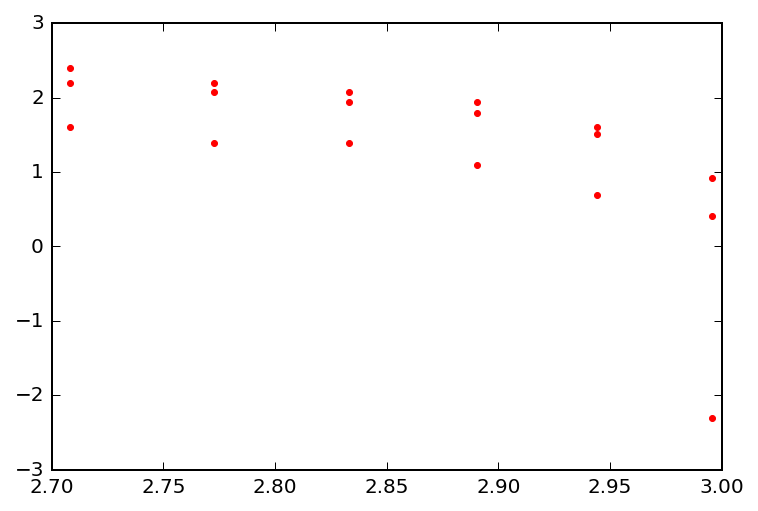

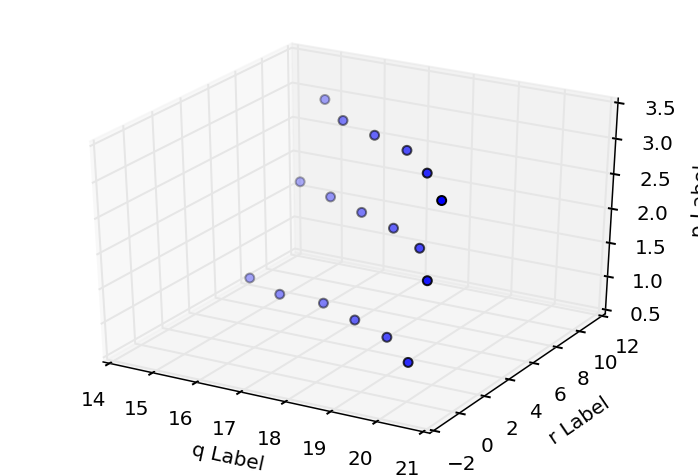

In [49]:
from gpfit.fit import fit
from numpy import logspace, log, log10, random


p = np.array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])  # "fuel mass"
print p
q = np.array([15, 16, 17, 18, 19, 20, 15, 16, 17, 18, 19, 20, 15, 16, 17, 18, 19, 20])  # "power"
print q
r = np.array([5, 4, 4, 3, 2, 0.1, 9, 8, 7, 6, 4.5, 1.5, 11, 9, 8, 7, 5, 2.5])  # "time between refueling"
# changed some values. nicely convex: [5, 4.6, 4, 3.1, 2, 0.1, 9, 8.3, 7.2, 6, 4.5, 1.5, 10, 9.3, 8.3, 7, 5, 2.5]
# doesn't actually seem to help much, in fitting at least
# original: [5, 4, 4, 3, 2, 0.1, 9, 8, 7, 6, 4.5, 1.5, 11, 9, 8, 7, 5, 2.5]
print r


import matplotlib.pyplot as plt
plt.plot(q, r, 'r.')
# plt.axis([14, 21, 0, 20])
plt.xlabel('q')
plt.ylabel('r')
plt.show()

m = log(q)
n = log(r)
plt.plot(m, n, 'r.')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(q, r, p)
ax.set_xlabel('q Label')
ax.set_ylabel('r Label')
ax.set_zlabel('p Label')
plt.show()




In [50]:

u = np.array([q, r])
print u
w = p
print w


x = log(u)
y = log(w)
print x
print y

    
K=2     # what is this?  higher means a closer fit?  kinda. I think just number of fitting curves (terms) allowed
        # can't get above K=3 without getting too large or small of a coefficient. are my data points that bad?

# fixed initial guess for fitting. so it's not different every time
random.seed(33404)
    
    
cMA, errorMA = fit(x, y, K, "MA")  
print "MA RMS Error: %.5g" % errorMA

cSMA, errorSMA = fit(x, y, K, "SMA")               # after choosing p as dependent, now off by 0.01 to 0.09
print "SMA RMS Error: %.5g" % errorSMA              

cISMA, errorISMA = fit(x, y, K, "ISMA")     
print "ISMA RMS Error: %.5g" % errorISMA
                                                    # these errors dont seem right. plugged ind. variable data
                                                    # back into the function and got outputs off by 0.1 to 0.5
                                                    # 



[[ 15.   16.   17.   18.   19.   20.   15.   16.   17.   18.   19.   20.
   15.   16.   17.   18.   19.   20. ]
 [  5.    4.    4.    3.    2.    0.1   9.    8.    7.    6.    4.5   1.5
   11.    9.    8.    7.    5.    2.5]]
[1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3]
[[ 2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227
   2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227
   2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227]
 [ 1.60943791  1.38629436  1.38629436  1.09861229  0.69314718 -2.30258509
   2.19722458  2.07944154  1.94591015  1.79175947  1.5040774   0.40546511
   2.39789527  2.19722458  2.07944154  1.94591015  1.60943791  0.91629073]]
[ 0.          0.          0.          0.          0.          0.
  0.69314718  0.69314718  0.69314718  0.69314718  0.69314718  0.69314718
  1.09861229  1.09861229  1.09861229  1.09861229  1.09861229  1.09861229]
w = 4.15269 * (u_1)**-0.444703 * (u_2)**0.16751
w = 3.69263e-09 * (u_1)**6.50

ValueError: Fitted constraint contains too small a value...